In [1]:
import numpy as np
import numba
import matplotlib.pyplot as plt

In [2]:
beta =0.995
delta = 1.5
theta = 0.25

In [3]:
bc_tran = np.array([[0.9375, 0.0625],[0.0625,0.9375]], dtype=np.float64)
# gg gb
# bg bb
pieg = np.array([[0.975, 0.025],[0.6,0.4]], dtype=np.float64)
pieb = np.array([[145/154, 9/154],[3/7,4/7]], dtype=np.float64)
# ee eu
# ue uu

In [4]:
# eg - eg, eg - ug, eg - eb, eg - ub
# ug  - eg, ug - ug, ug- eb, ug - ub
# eb - eg, eb - ug
# ub - eg, ub - ug

#s1 - s1, s1 - s2 ..
#s2 - s1, s2 - s2 ...

pie = np.repeat(bc_tran, 2, axis=0).repeat(2, axis=1) * np.tile(np.append(pieg, pieb, axis=1), (2, 1))

In [5]:
# s1 = eg
# s2 = ug
# s3 = eb
# s4 = ub
v = np.ones((301,4),dtype=np.float64)
a_grid = np.linspace(0., 8., 301)

In [6]:
# ggbb 301 * 4
y_vec = np.tile(np.append(np.ones((301,1), dtype=np.float64),theta * np.ones((301,1), dtype=np.float64), axis=1), (1,2))

In [7]:
c = (y_vec + a_grid.reshape(301,1)).repeat(301, axis=1).reshape(301,4,301) - a_grid.reshape(1,301).repeat(4, axis = 0).reshape(1,4,301)
c = np.clip(c, a_min=1e-8, a_max=10)

In [8]:
def value_iter(v, c, beta, delta, pie):
    n = 0
    err = 1.
    while err > 1e-8 and n <= 4000:
        
        vn = v.copy()
        expc = pie @ np.transpose(v)
        u = c ** (1 - delta) / (1 - delta)
        temp = u + beta * expc.reshape(1, 4, 301)
        v = np.max(temp, 2)
        
        if n % 10 == 0:        
            err = np.max(np.abs(v - vn))
            
        n += 1
    return vn, temp

In [9]:
@numba.njit
def value_iter_jit(v, c, beta, delta, pie):
    n = 0
    err = 1.
    
    while err > 1e-8 and n <= 4000:
        
        vn = v.copy()
        expc = pie @ np.transpose(v)
        u = c ** (1 - delta) / (1 - delta)
        temp = u + beta * expc.reshape(1, 2, 301)
        for i in range(301):
            for j in range(2):
                v[i,j] =  np.max(temp[i,j,:])

        if n % 10 == 0:        
            err = np.max(np.abs(v - vn))
            
        n += 1
    return vn, temp

In [10]:
vn, temp = value_iter(v, c, beta, delta, pie)
#vn,temp = value_iter_jit(v, c, beta, delta, pie)

In [11]:
plc = np.argmax(temp, axis=2)
#policy matrix

In [12]:
demo = np.ones((301,4), dtype=np.float64) / (301*4)

In [13]:
@numba.njit
def demo_iter(demo, plc, pie):
    err = 1.
    n = 0
    dims = pie.shape[1]
    while err > 1e-6 and n <= 4000:
        demon = np.zeros((301,dims), dtype=np.float64)
        for i in range(301):
            for j in range(dims):
                aprime = plc[i,j]
                demon[aprime,:]=demo[i,j]*pie[j,:] + demon[aprime,:]       
        
        if n % 5 == 0:        
            err = np.max(np.abs(demon - demo))
            
        demo = demon.copy()
        n += 1
    return demon, n

In [14]:
demon, times = demo_iter(demo, plc, pie)
np.abs(demon.sum()-1) < 1e-7
#sum == 1 confirmed

True

In [15]:
vb = np.sum(demon*vn)

In [16]:
vgood,  plcgood = value_iter_jit(v[:,0:2], c[:,0:2,:], beta, delta, pieg)
vbad, plcbad = value_iter_jit(v[:,2:4], c[:,2:4,:], beta, delta, pieb)
plcgood = np.argmax(plcgood, axis=2)
plcbad = np.argmax(plcbad, axis=2)

In [17]:
demogood, time1 = demo_iter(demo[:,0:2]*2, plcgood, pieg)
demobad, time2 = demo_iter(demo[:,2:4]*2, plcbad, pieb)

In [18]:
vnb = 0.5 * np.sum(demogood * vgood) + 0.5 * np.sum(demobad * vbad)

In [19]:
con_diff = (vnb/vb) ** (1/(1-delta)) -1

In [20]:
con_diff
#over...

-0.0008450318954589253

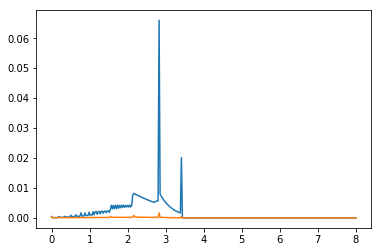

In [21]:
plt.plot(a_grid, demon[:,0])
plt.plot(a_grid, demon[:,1])

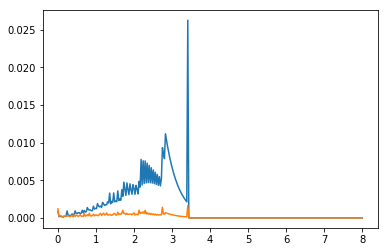

In [23]:
plt.plot(a_grid, demon[:,2])
plt.plot(a_grid, demon[:,3])

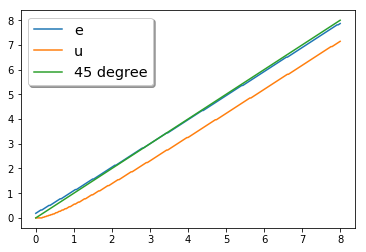

In [21]:
fig, ax = plt.subplots()
ax.plot(a_grid, plc[:,0]/37.5, label='e')
ax.plot(a_grid, plc[:,1]/37.5, label='u')
ax.plot(a_grid, a_grid, label='45 degree')

legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')

legend.get_frame()

plt.show()

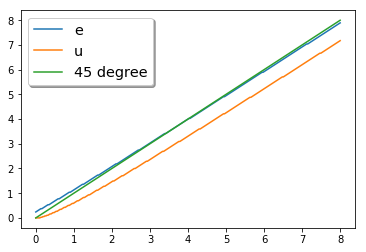

In [22]:
fig, ax = plt.subplots()
ax.plot(a_grid, plc[:,2]/37.5, label='e')
ax.plot(a_grid, plc[:,3]/37.5, label='u')
ax.plot(a_grid, a_grid, label='45 degree')

legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')

legend.get_frame()

plt.show()

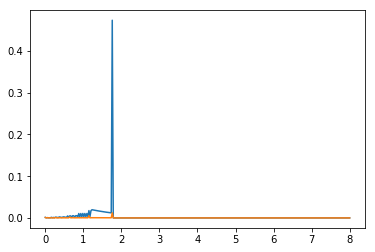

In [24]:
plt.plot(a_grid, demogood[:,0])
plt.plot(a_grid, demogood[:,1])

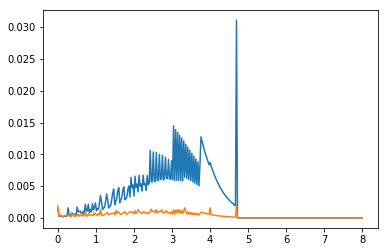

In [25]:
plt.plot(a_grid, demobad[:,0])
plt.plot(a_grid, demobad[:,1])

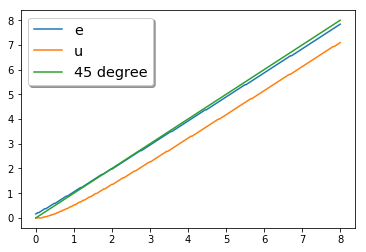

In [26]:
fig, ax = plt.subplots()
ax.plot(a_grid, plcgood[:,0]/37.5, label='e')
ax.plot(a_grid, plcgood[:,1]/37.5, label='u')
ax.plot(a_grid, a_grid, label='45 degree')

legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')

legend.get_frame()

plt.show()

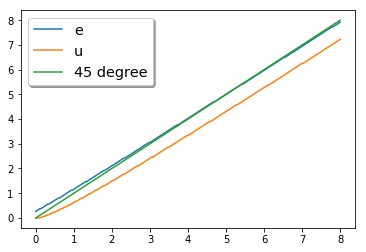

In [27]:
fig, ax = plt.subplots()
ax.plot(a_grid, plcbad[:,0]/37.5, label='e')
ax.plot(a_grid, plcbad[:,1]/37.5, label='u')
ax.plot(a_grid, a_grid, label='45 degree')

legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame()

plt.show()